In [1]:
#import packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import PorterStemmer
import string
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import log_loss
from scipy.sparse import lil_matrix

from sklearn.model_selection import KFold

#### Import Data

In [2]:
#import data
sms = pd.read_csv('SMSSpamCollection.csv', encoding='latin-1')
sms.head ()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# checking unnamed columns
sms['Unnamed: 3'].unique()

array([nan, ' MK17 92H. 450Ppw 16"', ' why to miss them', 'GE',
       'U NO THECD ISV.IMPORTANT TOME 4 2MORO\\""',
       'i wil tolerat.bcs ur my someone..... But',
       ' ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\\""',
       'whoever is the KING\\"!... Gud nyt"', ' TX 4 FONIN HON',
       ' \\"OH No! COMPETITION\\". Who knew', 'IåÕL CALL U\\""'],
      dtype=object)

* Seems like unnamed columns have parts of the messages that somehow were wrongly divided in csv.file. 
* Though it may affect classifier, decision is to drop them for simplicity

In [4]:
# drop unnecessary columns
sms1 = sms.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
sms1 = sms1.rename(columns={"v1":"class", "v2":"message"})
sms1.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# look at classes %
sms1['class'].value_counts() / len(sms1) * 100

ham     86.593683
spam    13.406317
Name: class, dtype: float64

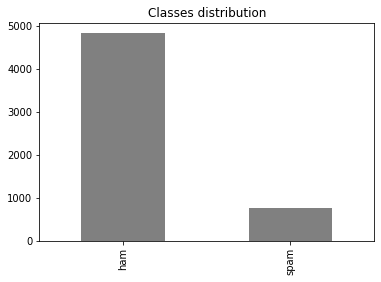

In [6]:
# look at classes counts
x=pd.value_counts(sms1["class"], sort= True)
x.plot(kind= 'bar', color= ["grey"])
plt.title('Classes distribution')
plt.show()

Sample is imbalanced

####  Metrics choice

Though receiving spam can be annoying, I think that situation, when actual message is classified as spam, can lead to worse consequenses: situations, when a person can miss important info or meeting just because he/she never checks spam folder.

So, the classifier should be focused on predicting ham correctly. If spam is predicted as 1, I need lower False positive rate and can allow for higher False negative rate = I need higher Precision

Main metric will be **precision**

####  By hands Naive Bayes

Tokenization

In [7]:
def process_text(text):
    tokenized=re.split('\W+',text)
    tokenized_no_punctuation=[word.lower() for word in tokenized if word not in string.punctuation]
    tokenized_no_stopwords=[word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    tokens = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    return tokens

sms1['tokens']=sms1['message'].apply(process_text)

In [8]:
# check tokenization
sms1.head()

,class,message,tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]"


Train / test split

In [9]:
# add labels for prediction
# spam = 1, ham = 0
sms1['spamlabel']=(sms1['class'] =='spam').astype(int)

In [10]:
#check
sms1.head()

,class,message,tokens,spamlabel
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre...",0
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, 2, wkli, comp, win, fa, cup, fin...",1
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]",0


In [11]:
#train/test split
index_train, index_test  = train_test_split(np.array(sms1.index), train_size=0.7, random_state=1)
train = sms1.loc[index_train,:].copy()
test =  sms1.loc[index_test,:].copy()

Exploration of word frequency

In [12]:
# frequent words in ham
ham =len(sms1[sms1['class']=='ham'])

words_ham = nltk.FreqDist()
for words in sms1[sms1['class']=='ham']['tokens']:
    for word in np.unique(words):
            words_ham[word] += 1
            
freq_words_ham = pd.Series(dict(words_ham))/ham
freq_words_ham = freq_words_ham.sort_values(ascending=False)
freq_words_ham.head(20).round(3)

u       0.144
go      0.080
get     0.069
come    0.057
ok      0.057
call    0.056
2       0.055
gt      0.050
lt      0.050
know    0.048
like    0.047
got     0.046
good    0.046
day     0.045
time    0.045
love    0.043
want    0.042
ur      0.040
4       0.037
need    0.035
dtype: float64

In [13]:
# frequent words in spam
spammessage =len(sms1[sms1['class']=='spam'])

words_spam = nltk.FreqDist()
for words in sms1[sms1['class']=='spam']['tokens']:
    for word in np.unique(words):
            words_spam[word] += 1
            
freq_words_spam = pd.Series(dict(words_spam))/spammessage
freq_words_spam = freq_words_spam.sort_values(ascending=False)
freq_words_spam.head(20).round(3)

call     0.447
å        0.320
free     0.228
txt      0.216
2        0.209
u        0.174
4        0.170
text     0.167
mobil    0.162
ur       0.153
claim    0.146
1        0.142
stop     0.135
repli    0.133
www      0.131
get      0.118
prize    0.115
uk       0.098
min      0.096
150p     0.095
dtype: float64

Probability count

In [14]:
# probability of message to be spam
message_in_spam = train['class'].value_counts()['spam'] / len(train)
# probability of message to be ham
message_in_ham = 1 - message_in_spam

print (message_in_spam)
print (message_in_ham)

0.13564102564102565
0.8643589743589744


In [15]:
# probability word in spam
def pspam(word):
    count = 0
    total_spam = train['class'].value_counts()['spam']
    for index, row in train.iterrows():
            if row['class']=='spam' and word in row['tokens']:
                count += 1  
    return count/total_spam

In [16]:
pspam('free')

0.22117202268431002

In [17]:
# probability word in spam correction for zero probability
def pspamzerocorr(word):
    if pspam(word) != 0:
        p = pspam(word)
    else: p = 1
    return p

In [18]:
pspamzerocorr('lvblb')

1

In [19]:
# probability word in ham
def pham(word):
    count = 0
    ttl_ham = train['class'].value_counts()['ham']
    for index, row in train.iterrows():
            if row['class']=='ham' and word in row['tokens']:
                count += 1
    return count/ttl_ham

In [20]:
pham ('free')

0.011865915158706615

In [21]:
# probability word in ham correction for zero probability
def phamzerocorr(word):
    if pham(word) != 0:
        ph=pham(word)
    else: ph = 1
    return ph

In [22]:
# Probability message is spam given a word
def condprobability(word):
        proba = (pspamzerocorr(word)*message_in_spam)/((pspamzerocorr(word)*message_in_spam + phamzerocorr(word)*message_in_ham))
        return proba

In [23]:
# let's see:
word = 'free'
print('Probability that a message is spam given the word "{}" is: {}'.format(word, condprobability(word)))

Probability that a message is spam given the word "free" is: 0.7452229299363057


One word can be an unreliable source of info and lead to misclassification, so classifier won't be tested on test sample, I proceed to multiple word classifier

**Multiple-words Naive Bayes & 5-fold validation**

In [24]:
# define function to classify multiple words
def classify(message):
    p_spam_given_message = message_in_spam
    p_ham_given_message = message_in_ham
    for word in message:
        p_spam_given_message *= pspamzerocorr(word)
        p_ham_given_message *= phamzerocorr(word)
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'

In [25]:
classify('u')

'ham'

In [26]:
classify('free')

'spam'

In [29]:
classify(['i', 'sell', 'pizza'])

'spam'

In [30]:
classify(['find', 'my', 'socks'])

'ham'

In [ ]:
#apply predictions to test set
test['predicted'] = test['tokens'].apply(classify)

The function wasn't executed for more than an hour - probably, bug in the code (too many loops or smth) but I couldn't debug it so I couldn't fit the model

So, next steps would have been **5-fold** cross validation:

In [135]:
#applying cross-validation
kf = KFold(n_splits=5, random_state=1, shuffle=False)
kf.get_n_splits(sms1)

5

In [136]:
#split
for train_index, test_index in kf.split(sms1):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = sms1['tokens'][train_index], sms1['tokens'][test_index]
    y_train, y_test = sms1['class'][train_index], sms1['class'][test_index]

TRAIN: [1115 1116 1117 ... 5569 5570 5571] TEST: [   0    1    2 ... 1112 1113 1114]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [1115 1116 1117 ... 2227 2228 2229]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [2230 2231 2232 ... 3341 3342 3343]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [3344 3345 3346 ... 4455 4456 4457]
TRAIN: [   0    1    2 ... 4455 4456 4457] TEST: [4458 4459 4460 ... 5569 5570 5571]


In [124]:
# exctract using indices
train_1 = pd.DataFrame([data['class'][1115:5571], data['tokens'][1115:5571]]).transpose()
test_1 = pd.DataFrame([data['class'][0:1114], data['tokens'][0:1114]]).transpose()

train_2 = pd.DataFrame([data['class'][0:5571], data['tokens'][0:5571]]).transpose()
test_2 = pd.DataFrame([data['class'][1115:2229], data['tokens'][1115:2229]]).transpose()

train_3 = pd.DataFrame([data['class'][0:5571], data['tokens'][0:5571]]).transpose()
test_3 = pd.DataFrame([data['class'][2230:3343], data['tokens'][2230:3343]]).transpose()

train_4 = pd.DataFrame([data['class'][0:5571], data['tokens'][0:5571]]).transpose()
test_4 = pd.DataFrame([data['class'][3344:4457], data['tokens'][3344:4457]]).transpose()

train_5 = pd.DataFrame([data['class'][0:4457], data['tokens'][0:4457]]).transpose()
test_5 = pd.DataFrame([data['class'][4458:5571], data['tokens'][4458:5571]]).transpose()

In [ ]:
#applying predictions to test sets
test_1['predicted'] = test_1['tokens'].apply(classify)
test_2['predicted'] = test_2['tokens'].apply(classify)
test_3['predicted'] = test_3['tokens'].apply(classify)
test_4['predicted'] = test_4['tokens'].apply(classify)
test_5['predicted'] = test_5['tokens'].apply(classify)

In [ ]:
# evaluating precision
precision_1 = precision_score(test_1['class'], test_1['predicted'], average=None)
precision_2 = precision_score(test_2['class'], test_2['predicted'], average=None)
precision_3 = precision_score(test_3['class'], test_3['predicted'], average=None)
precision_4 = precision_score(test_4['class'], test_4['predicted'], average=None)
precision_5 = precision_score(test_5['class'], test_5['predicted'], average=None)

# getting avg
precision_avg = sum(precision_1,precision_1,precision_1,precision_1,precision_1)/5

**sk_learn Bayes**

In [140]:
sms1['spamlabel']=(sms1['class'] =='spam').astype(int)

In [141]:
# define dependent var & regressor
x = sms1['message']
y = sms1['spamlabel']

In [142]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [143]:
# transforming X_train
vect = CountVectorizer(stop_words = 'english')
X_train_matrix = vect.fit_transform(X_train) 

In [144]:
# applying Multinomial NB
clf=MultinomialNB()
clf.fit(X_train_matrix, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [145]:
# confusion matrix
X_test_matrix = vect.transform(X_test) 
predicted_result=clf.predict(X_test_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test,predicted_result))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1194
           1       0.95      0.91      0.93       199

    accuracy                           0.98      1393
   macro avg       0.97      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [146]:
# 5-fold validation
scores = cross_val_score(clf, X_train_matrix, y_train, cv = 5, scoring='precision')
print('Cross-validation precision scores:{}'.format(scores))

Cross-validation precision scores:[0.87804878 0.87719298 0.88983051 0.8974359  0.9122807 ]


In [147]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.8910


Though in confusion matrix precision is at 97%, based on cross-validation we can say that avg precision score is around 89%. It even can be as low as 87% = for the purposes of avoiding misclassification of normal letters as spam this model should be improved

**Final comments**: as I couldn't test by hands metric on test set I can't compare th results. I can conclude that in-built functions results can be improved by building classifiers through feature extraction. Probably by hand classifier allows for even more tuning and can achieve same or better results than a built-in one